In [1]:
from __future__ import annotations
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

# **Reinforced Learning for Blackajack**

In this project we will use the gymnasium environment for blackjack.   

We will first describe the game of **blackjack**, and then dwell on how the game is modeled with the **gymnasium environment**.    

Then we will implement models and confront them:    
  
- A **Random model** will be used as benchmark and for making performance measures and plots   

- **Q-learning (TD)** because is much used in the game   

- **SARSA (TD)** for making hypotesis about on-policy vs off-policy in this context   

- **Monte Carlo** for providing a defense of on-policy methods and try to replicate the Sutton e Barto Blackjack example

## **Blackjack in real life**

Blackjack objective is to obtain cards whose summation is as great as possible without exceeding 21.   

**Card values** are:   

- Face cards (Jack, Queen, King) have a point value of 10.

- Aces can either count as 11 (called a **‘usable ace’**) or 1.

- Numerical cards (2-9) have a value equal to their number.


**The game starts** with the dealer having one face up and one face down card, while the player has two face up cards.   
All cards are drawn from an infinite deck (this is done by continuing shuffling the deck).

Then the player turns over the card, if he has 21 immediately (an ace and a 10-card) it is called a **natural**.
He then wins unless the dealer also has a natural, in which case the game is a **draw**.

If the player does not have a natural, then he can request additional
cards, one by one (**hits**), until he either stops (**sticks**) or exceeds 21 (goes **bust**). 
- If he goes bust, he loses
- if he sticks, then it becomes the dealer’s turn. 

The **dealer** then turn out his covered card and then follows a fixed strategy without choice: 
- he sticks on any sum of 17 or greater
- he hits otherwise.

If the dealer goes bust, then the player wins;
otherwise, the outcome —win, lose, or draw—is determined by whose final sum is closer to 21.

For simplicity we are not going to consider betting strategies, "splitting the cards" and multi player rules and approaches 

## **Blackjack in gymnasium**

In the Gymnasium environment, the game works exactly as explained before.  
So lets study how it is modeled:

**The action space**

The player's possible actions are modeled as a one-dimensional array with two possibilities:

- 0: Stick (stop asking for cards)

- 1: Hit (ask for another card)


**The observation space**  

The case in wich the player and the dealer can find themselves in is modelled as a tuple in the form (int(), int(), int()).   
The tree elements contain:

- the player’s current points: 32 different states

- the value of the dealer’s one showing card (1-11 cause aces can be 1 or 11)

- whether the player holds a usable ace (0 or 1), a usable ace value is 11

Note: An ace will always be counted as usable (11) unless it busts the player.

ex.    
the player has 2 cards, 7 and 3 while the dealer has a 4, the player therefore decide to not ask any card (stick)
in this case the observation is (10, 4, 0)

**Rewards**   

Three possible rewards:

- win game:  + 1

- lose game: - 1

- draw game:   0   


**The episode ends if the following happens:**

- The player hits and the sum of hand exceeds 21.

- The player sticks.   

   
   
     
      
     
   
**Note:**
    
We assume that cards are dealt from an infinite deck (i.e., with replacement).   
 
This, in addition to mimicking the real casino strategy of constantly shuffling the cards, also allows you not to focus on an approach oriented towards   
counting the remaining cards, an approach formally prohibited in casinos.  

## **Environment Setup**

In our environment we decided not to count the "natural win" in wich the player gets 21 with his initial two cards  
and the dealer does not.

This approach is explained by the fact that this type of win is obtained without choises so considered not useful for learning.   
For this reason we have to set:
- ``natural``= false
- and therefore diverge from the Sutton & Barto example  ``sab=False``

In [3]:
env = gym.make('Blackjack-v1', natural=False, sab=False)
n_episodes = 100000

Than we proceed to study what useful attributes and methods the enviroment provides to us, we selected these ones.

**Usefull environment attributes**

- ``action_space``: Defines the space of possible actions that the agent can take in the environment.


- ``observation_space``: Describes the space of possible observations (states) that the environment can provide to the agent.

- ``reward_range``: Specifies the possible range of rewards that the agent can receive from the environment, typically a tuple like

- ``metadata``: A dictionary that contains additional information about the environment, such as the rendering modes supported or the version of the environment.

In [4]:
# check that main attributes are properly set 
useful_attributes= ['action_space',"observation_space", 'reward_range','metadata']

def print_env_attribute(env, attribute_name):
    attribute_value = getattr(env, attribute_name)
    print(f"The environment attribute .{attribute_name} is {attribute_value}")

def print_useful_attributes(env):
    for attribute_name in useful_attributes:
        print_env_attribute(env, attribute_name)
print_useful_attributes(env)

The environment attribute .action_space is Discrete(2)
The environment attribute .observation_space is Tuple(Discrete(32), Discrete(11), Discrete(2))
The environment attribute .reward_range is (-inf, inf)
The environment attribute .metadata is {'render_modes': ['human', 'rgb_array'], 'render_fps': 4}


In [5]:
# make example of first state to check that it works

# initial state using reset 
done = False
initial_state, info = env.reset()

# sample a random action and go to next state 
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)

# show the initial state
print()
print(f"The initial state in this example is {initial_state}")
print()
print(f"Where:")
print()
print(f"{initial_state[0]} is player current sum of his 2 initial cards")
print(f"{initial_state[1]} is value of the dealer face up card")
print(f" {initial_state[2]} is if the player holds a usable ace (1) or not (0)")
print()
print(f"Next state after action: {observation}")
      
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")
print(f"Info: {info}")


The initial state in this example is (18, 4, 0)

Where:

18 is player current sum of his 2 initial cards
4 is value of the dealer face up card
 0 is if the player holds a usable ace (1) or not (0)

Next state after action: (28, 4, 0)
Reward: -1.0
Terminated: True
Truncated: False
Info: {}


## **Random Agent**
 
The random model has the structure of the other models, although it is mostly an empty shell that silmply does a random action in every state.  
  
However since there are only 2 actions it will serve as a benchmark to beat, not without difficulty, and as a basis for creating the performance measures and graphs that we will use for the next models. 


In [6]:
class Agent_random:

    # no learning parameters cause random

    def __init__(self):
        pass  

    # Perform random action
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # random action
        return env.action_space.sample()

    # no update, kept to ensure comparison with Q learning
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        pass  

   # no epsilon decay 
    def decay_epsilon(self):
        pass  


# create the radnom aagent 
agent_random =  Agent_random()

# create env_rnirnoment with statistics 
env_rn = gym.wrappers.RecordEpisodeStatistics(env, deque_size= n_episodes)


# training 
for episode in tqdm(range(n_episodes)):
    obs, info = env_rn.reset()
    done = False

    # play episode
    while not done:
        # get random action, perform it to obtain next obs e reward
        action = agent_random.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_rn.step(action)

        # update does nothing
        agent_random.update(obs, action, reward, terminated, next_obs)

        # when episode ends because of time or because finished stop
        done = terminated or truncated
        obs = next_obs
        
    # epsilon decay does nothing 
    agent_random.decay_epsilon()

  0%|          | 223/100000 [00:00<06:49, 243.83it/s]

100%|██████████| 100000/100000 [01:15<00:00, 1332.52it/s]


## **Measure Performance**
For Performance measure we will use:
- **Percentage of Winning rate** over episodes
- **Percentage of Loss** rate over episodes
- **Average length of the episode**, usefull for checking the "survival time" of the agent

In [7]:
def performance(env, model_name:str):  
    wins = 0 
    loss= 0 

    # take returns and lenght of the environment 
    env_returns_list = [returns[0] for returns in env.return_queue]  
    env_length_list = [length[0] for length in env.length_queue]

    # if return positive the episode was a win, if negative  loss
    for reward in env_returns_list:
        if reward > 0:
            wins += 1
        elif reward < 0:
            loss += 1
    # percentage of win, lossa and average length of the game
    winsoveround = wins / n_episodes
    lossoveround = loss / n_episodes

    average_round_length = np.average(env_length_list)

    perf = [ winsoveround, lossoveround, average_round_length ]

    # add name of the model

    perf.insert(0, model_name)

    return perf

def performance_table(env, model_name:str):

    # table columns
    columns = ["Model Name", "Winning Percentage", "Loss Percentage", "AVG Episode Length"]

    df = pd.DataFrame(columns=columns)

    # compute model performance meas
    model_da_aggiungere = performance(env, model_name)

    # add them to table
    df.loc[len(df)] = model_da_aggiungere

    return df

def add_perfomrance_totable(env, model_name:str, df):

    new_row = performance(env, model_name)
    
    df.loc[len(df)] = new_row

    return df




df = performance_table(env_rn, "Random Model")
df




,Model Name,Winning Percentage,Loss Percentage,AVG Episode Length
0,Random Model,0.28036,0.67579,1.37603


## **Plot Performance**
Given the fact that the reward is positive for winning and negative for loss we will plot the rewards over the episodes

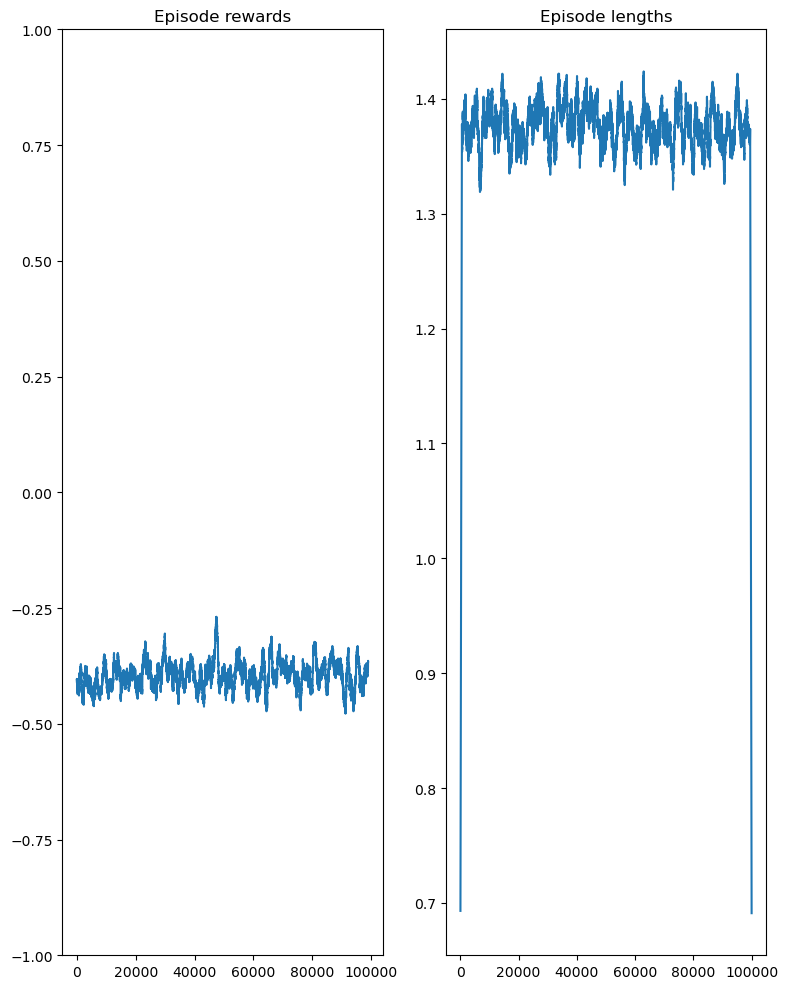

In [8]:

rolling_length = 1000
# make training plot 

fig, axs = plt.subplots(ncols=2, figsize=(8, 10))


# "Episode rewards" plot 

axs[0].set_title("Episode rewards")

# moving average of rewards to get smoother graph
reward_moving_average = (

    # convolve the array of returns with array of ones long as the rolling window
    # this create the moving average if divided by rolling lenght 

    np.convolve(
        np.array(env_rn.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    # divide by rolling length to get rolling avg 
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylim(-1, 1)

# "Episode lengths" plot 

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env_rn.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
length_moving_average = length_moving_average[1:-1]

axs[1].plot(range(len(length_moving_average)), length_moving_average)


plt.tight_layout()
plt.show()

## **The dynamic programming problem**

Dynamic Programming seemed the first method to be tested to solve Blackjack.   
The DP is in fact a model based method that requires a perfect knowledge of the environment, which is feasible in a “simple and fixed” game like BJ.

However although **it seems permissible in theory**, in practice it is not a well-applicable methodology.    
For while the probability p(S', R | S, A) may be known in this game, it is in fact **very difficult to compute** (as demonstrated by Sutton and Barto).   
 
For example, supposing the player’s sum is 14 and he chooses to stick.   
The probability of going to next state S' terminating with a reward of +1 is not easily calulated as a function of the dealer’s showing card, plus the episodes tend to be very short for computing the probability table.   
This can be seen even more clearly by taking the Expected reward per state-action pair:  
  
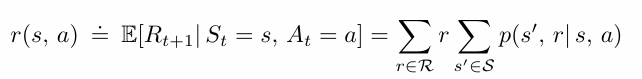

Here it becomes clear how if even feasible in theory to sum for all possible next state becomes computationally expensive.   

Although it seems an ideal case for model-based methods in reality we will have to apply **Model-Free methodologies**



## **Temporal Difference Learning (TD)**

Since Q-learning is one of the most widely used methods for Blackjack we decided to start with TD.




Temporal Difference (TD) is a methodology that combines:
- the **model free** approach of the Monte Carlo methods
- the **bootstrapping** approach of the Dynamic Programming

The peculiarity of TD is that only the next time step is needed for updating the value function   
(thanks to the recursive Gt formulation)   

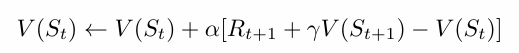

The most important control methods in this family are the :
- Q learnign (off policy)
- SARSA (on policy)

In this project we will therefore try to apply both to compare them, starting with Q learning because it is most used in blackjack.



### **Q LEARNING**

Q learning update formula is :   

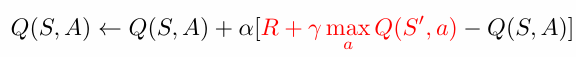


It is off-policy because regardless of the policy that is currently following (that could also perform exploration because it's E-soft) it will try to follow the optimal policy going forward (choosing the best possible actions).    
In the fomrula is expressed by the fact that no matter the policy that is following it will follow the maximum Q-value of the next state Q(St+1,a).

The algorithms is: 

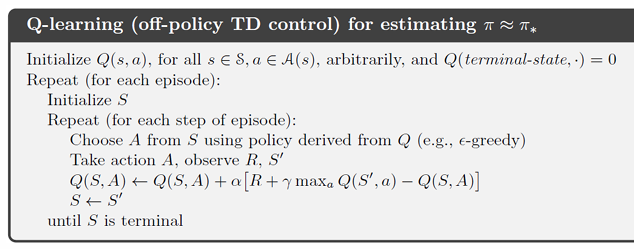

In [9]:
class BlackjackAgent_qlearning:

    # learning parameters 
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 1,  ):
   
        # Q(S,A) table has for every state 2 possible actions so is a table with n rows and 2 columns
        
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # defaultdict returns default if error key 

        # learning rate alpha is constant
        self.lr = learning_rate
        # discount factor gamma constant
        self.discount_factor = discount_factor

        # epsilon for epsilon-greedy selection is decreasing 
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # in td we keep training error (the temporal diffference error)
        self.training_error = []

    # Perform epsilon-greedy action

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        
        # with probability epsilon perform a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (take action with higest Q value)
        else:
            return int(np.argmax(self.q_values[obs]))
        
    # Update Q table 

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        # Q(St, A) = Q(St, A) + Learning rate * [Rt+1 + gamma*max[Q(St+1, A)] - Q(St, A)]**\
        
        # future_q_value = max[Q(St+1, A)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        # temporal difference error = [Rt+1 + gamma*max[Q(St+1, A)] - Q(St, A)]
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        # Updated Q(S,A) as Q(St, A) + Learning rate * temporal difference error
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        # track training error
        self.training_error.append(temporal_difference)


# use decading epsilon, reduce epsilon by decay till final epsilon 
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)


#TRAINING

# hyperparameters
learning_rate  =  0.001

start_epsilon  =  1.0

epsilon_decay  =  start_epsilon / (n_episodes / 2) 
final_epsilon  =  0.00001


agent_ql =  BlackjackAgent_qlearning(
                learning_rate = learning_rate,
                initial_epsilon = start_epsilon,
                epsilon_decay = epsilon_decay,
                final_epsilon = final_epsilon, )

# create env_qlirnoment with statistics 
env_ql = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)


# training 
for episode in tqdm(range(n_episodes)):
    obs, info = env_ql.reset()
    done = False

    # play one episode
    while not done:
        action = agent_ql.get_action(obs)
        next_obs, reward, terminated, truncated, info = env_ql.step(action)

        # update the agent_ql
        agent_ql.update(obs, action, reward, terminated, next_obs)

        # update if the env_qlironment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent_ql.decay_epsilon()

100%|██████████| 100000/100000 [01:15<00:00, 1317.92it/s]


### **Q Learning Performance**

In [11]:
df = performance_table(env_rn, "Random Model")
df2 = add_perfomrance_totable(env_ql, "Q learning",df)
df2


,Model Name,Winning Percentage,Loss Percentage,AVG Episode Length
0,Random Model,0.28036,0.67579,1.37603
1,Q learning,0.38618,0.53903,1.45520


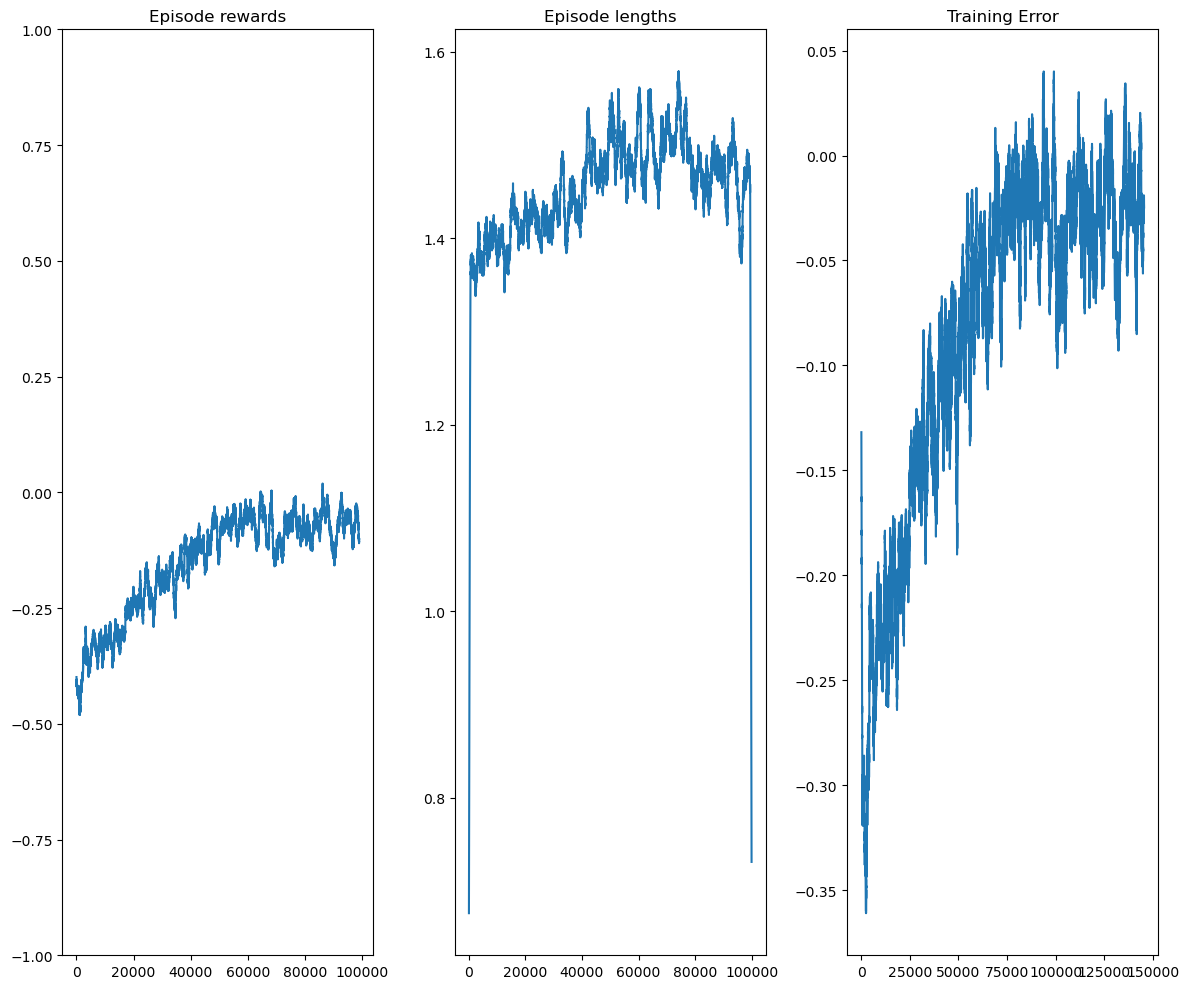

In [12]:
rolling_length = 1000
# make training plot 

fig, axs = plt.subplots(ncols=3, figsize=(12, 10))


# "Episode rewards" plot 

axs[0].set_title("Episode rewards")

# moving average of rewards to get smoother graph
reward_moving_average = (

    # convolve the array of returns with array of ones log as the rolling 
    # this will create an array with the moving sum of the returns
    # here the first return is the sum of the first 50 returns and so on 
    np.convolve(
        np.array(env_ql.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    # divide by rolling length to get rolling avg 
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylim(-1, 1)

# "Episode lengths" plot 

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env_ql.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)

axs[1].plot(range(len(length_moving_average)), length_moving_average)


# "Training Error" plot 

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent_ql.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)

axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()



We were able to overcome the random model, however, even by changing the number of events and learning parameters, the model does not improve.

In order to visualize the perfomrance graphically now we can also used a third graph, the temporal difference error.

## **Plot the policy**

Before changing the method, we can plot the policy, dividing it into two schemas:   
- Policy with usable ace (which is worth 11)   
- Policy with unusable ace (which is worth 1)   
   
By doing this we can compare the policy in our model with what is the standard optimal policy in “simple” blackjack

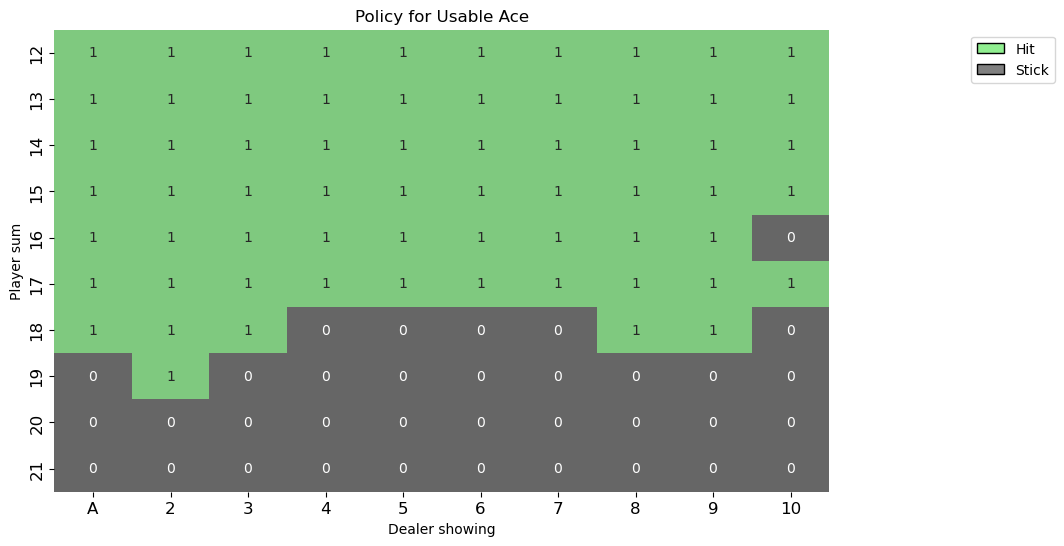

In [13]:
def create_policy_grid(agent, usable_ace=False):

    # Convert our state-action values to state values
    state_value = defaultdict(float)
    policy = defaultdict(int)

    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))


    # divide the plot into two plot, usable ace and unusable ace cases
    if usable_ace:
        player_count, dealer_count = np.meshgrid(
            # Players count, dealer's face-up card
            np.arange(12, 22),  # Should be between 12 and 21 for usable ace
            np.arange(1, 11),  # Dealer's cards
        )

        # Create the policy grid for plotting
        policy_grid = np.apply_along_axis(
            lambda obs: policy[(obs[0], obs[1], usable_ace)],
            axis=2,
            arr=np.dstack([player_count, dealer_count]),
        )

        # transpose to have it similar to the optimal table layout
        policy_grid = policy_grid.T


    else:
        player_count, dealer_count = np.meshgrid(
            # Players count, dealer's face-up card
            np.arange(4, 22),  # Should be between 4 and 21 for unusable ace
            np.arange(1, 11),  # Dealer's cards
        )

        policy_grid = np.apply_along_axis(
            lambda obs: policy[(obs[0], obs[1], usable_ace)],
            axis=2,
            arr=np.dstack([player_count, dealer_count]),
        )
        policy_grid = policy_grid.T

    return policy_grid


def create_policy_plot(policy_grid, usable_ace):
    # Create a new figure for the policy grid
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)

    if usable_ace:
        ax.set_title(f"Policy for Usable Ace")
        ax.set_yticklabels(range(12, 22), fontsize=12)  # Set correct labels for Usable Ace
    else:
        ax.set_title(f"Policy for Unusable Ace")
        ax.set_yticklabels(range(4, 22), fontsize=12)  # Set correct labels for Unusable Ace

    ax.set_ylabel("Player sum")
    ax.set_xlabel("Dealer showing")
    ax.set_xticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # Add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    plt.show()  # Display the plot


# Example usage
policy_grid_ql = create_policy_grid(agent_ql, usable_ace=True)
create_policy_plot(policy_grid_ql, usable_ace=True)


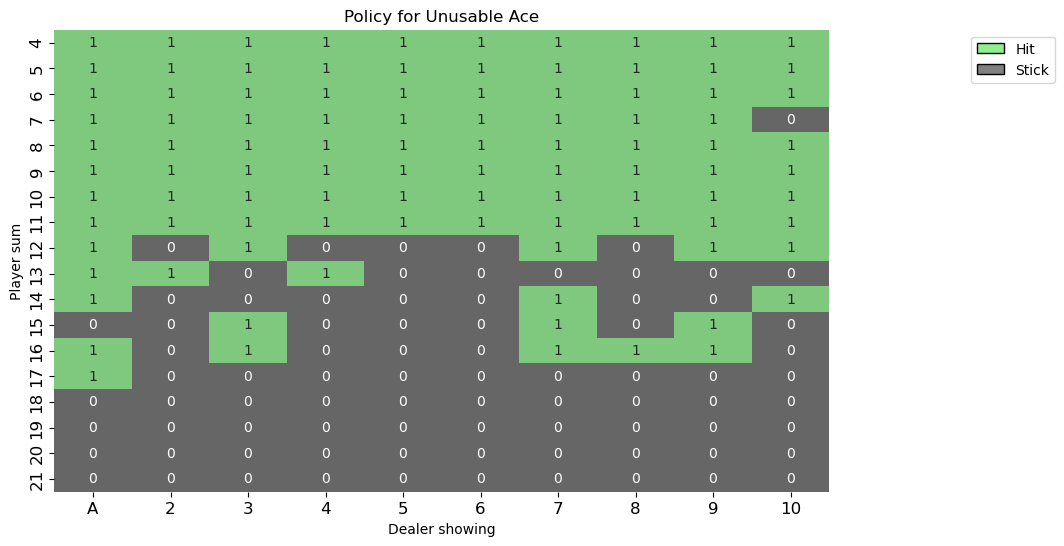

In [14]:
policy_grid_ql = create_policy_grid(agent_ql, usable_ace=False)
create_policy_plot(policy_grid_ql, usable_ace=False)

The optimal Policy in the unusable case is:   
   
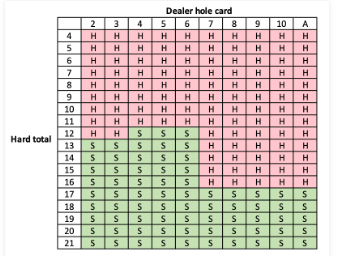

While in the usable case is:   
  

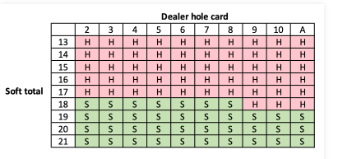


We therefore see that the extreme cases are handled but the agent is not performing optimally.   
Since even by increasing the epochs and changing the parameters the model does not improve and flattens out we can switch to the SARSA method to see how it perfom.



## **SARSA**

It is **on policy** since we are estimating the Q-function for the ϵ-soft policy that we
are using to collect data and which is improved.

Sarsa is guaranteed to converge to the optimal policy if:
- α satisfies Robbins-Monro conditions 
- Greedy in the Limit of Infinite Exploration (GLIE)


At the beginning we will use a constant learning rate,   
then we will modify the code to implement a "SARSA2" that decreases the α at every episode using α = 1/n ensuring the 2 requirements for converging to optimal policy.

The **SARSA algorithm** is:  

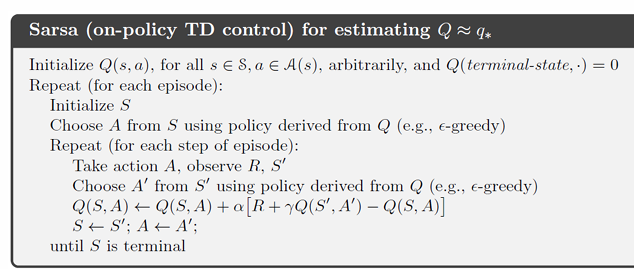

In [15]:
class Blackjackagent_sarsa:
    # learning parameters 
    def __init__(
        self,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,

        learning_rate: float,

        discount_factor: float = 1,

        ):
   
        # Q(S,A) table has for every state 2 possible actions so is a table with n rows and 2 columns
        
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n)) # defaultdict returns default if error key 

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # add decay discount factor for GLIE
        self.learning_rate =  learning_rate

        self.discount_factor = discount_factor


        self.training_error = []
        
    # Perform epsilon-greedy action

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        
        # with probability epsilon perform a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (take action with higest Q value)
        else:
            return int(np.argmax(self.q_values[obs]))
        

    # Update Q table, here we need also next action 

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        
        next_obs: tuple[int, int, bool],
        next_action: int
    ):
        # Q(St, A) = Q(St, A) + Learning rate * [Rt+1 + Q(St+1, At+1)] - Q(St, A)]**\
        
        # future_q_value = Q(St+1, At+1)
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]

        # temporal difference = [Rt+1 + gamma*max[Q(St+1, A+1)] - Q(St, A)]
        temporal_difference = (
            reward + + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        # Updated Q(S,A)
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.learning_rate * temporal_difference
        )
        # track training error
        self.training_error.append(temporal_difference)

    
    # use decading epsilon, reduce epsilon by decay till final epsilon 
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)



#TRAINING


# hyperparameters
learning_rate  =  0.001


start_epsilon  =  1.0
epsilon_decay  =  start_epsilon / (n_episodes / 2) 
final_epsilon  =  0.00001

agent_sarsa =  Blackjackagent_sarsa(

                initial_epsilon = start_epsilon,
                epsilon_decay = epsilon_decay,
                final_epsilon = final_epsilon,
                learning_rate= learning_rate

                 )

# create env_qlirnoment with statistics 
env_sarsa = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)



# training change because sarsa is different 

for episode in tqdm(range(n_episodes)):
    obs, info = env_sarsa.reset()
    done = False
    action = agent_sarsa.get_action(obs)

    # play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa.step(action)

        # next action 
        next_action =  agent_sarsa.get_action(next_obs)
        # update if the env_qlironment is done and the current obs
        agent_sarsa.update(obs, action, reward, terminated, next_obs,next_action)



        done = terminated or truncated
        obs = next_obs

    agent_sarsa.decay_epsilon()




100%|██████████| 100000/100000 [01:16<00:00, 1310.90it/s]


In [16]:
df3 = add_perfomrance_totable(env_sarsa, "SARSA1",df2)
df3

,Model Name,Winning Percentage,Loss Percentage,AVG Episode Length
0,Random Model,0.28036,0.67579,1.37603
1,Q learning,0.38618,0.53903,1.45520
2,SARSA1,0.26265,0.69293,1.52090


The Sarsa performs even worse than the Random Model, so we try with an alpha that decreases following 1/ n .

## **SARSA with learning rate 1/n**

In [17]:
class BlackjackAgent_sarsa2:
    # learning parameters 
    def __init__(
        self,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 1,
    ):
        # Q(S,A) table has for every state 2 possible actions so is a table with n rows and 2 columns
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))  # defaultdict returns default if error key 

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        

        # learning rate 1/n using iteration number that increase the count of n episodes
        self.iteration_number = 1  
        self.learning_rate = 1 / self.iteration_number  
        self.discount_factor = discount_factor

        self.training_error = []
        
    # Perform epsilon-greedy action
    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # with probability epsilon perform a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        # with probability (1 - epsilon) act greedily (take action with highest Q value)
        else:
            return int(np.argmax(self.q_values[obs]))
        
    # Update Q table 
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
        next_action: int
    ):
        # Q(St, A) = Q(St, A) + Learning rate * [Rt+1 + Q(St+1, At+1)] - Q(St, A)]**\
        
        # future_q_value = Q(St+1, At+1)
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]

        # temporal difference = [Rt+1 + gamma*max[Q(St+1, A+1)] - Q(St, A)]
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        # Updated Q(S,A)
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.learning_rate * temporal_difference
        )
        # track training error
        self.training_error.append(temporal_difference)

    # Use decaying epsilon, reduce epsilon by decay till final epsilon 
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    # Update learning rate based on the current iteration number
    def decay_learning_rate(self):
        self.iteration_number += 1  # Increment iteration number
        self.learning_rate = 1 / self.iteration_number  # Update learning rate

# TRAINING

# Hyperparameters

start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.0001

agent_sarsa2 = BlackjackAgent_sarsa2(
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# Create environment with statistics 
env_sarsa2 = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# Training loop
for episode in tqdm(range(n_episodes)):
    obs, info = env_sarsa2.reset()
    done = False
    action = agent_sarsa2.get_action(obs)

    # Play one episode
    while not done:
        next_obs, reward, terminated, truncated, info = env_sarsa2.step(action)

        # Next action 
        next_action = agent_sarsa2.get_action(next_obs)
        # Update Q-values
        agent_sarsa2.update(obs, action, reward, terminated, next_obs, next_action)

        done = terminated or truncated
        obs = next_obs

    # Decay epsilon and learning rate after each episode
    agent_sarsa2.decay_epsilon()
    agent_sarsa2.decay_learning_rate()



100%|██████████| 100000/100000 [01:18<00:00, 1271.36it/s]


In [18]:
df4 = add_perfomrance_totable(env_sarsa2, "SARSA2",df3)
df4

,Model Name,Winning Percentage,Loss Percentage,AVG Episode Length
0,Random Model,0.28036,0.67579,1.37603
1,Q learning,0.38618,0.53903,1.45520
2,SARSA1,0.26265,0.69293,1.52090
3,SARSA2,0.25806,0.69798,1.52019


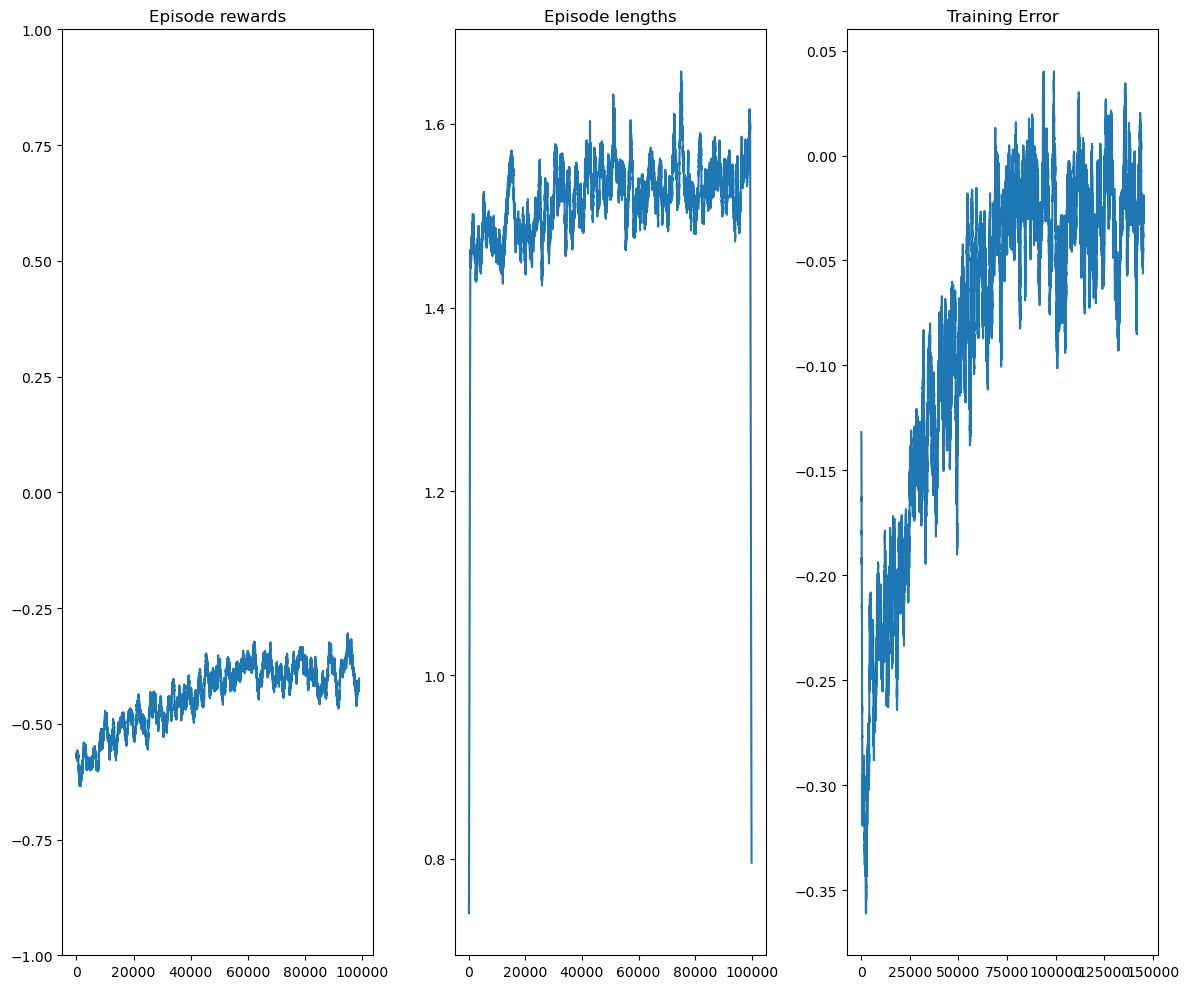

In [19]:
rolling_length = 1000
# make training plot 

fig, axs = plt.subplots(ncols=3, figsize=(12, 10))


# "Episode rewards" plot 

axs[0].set_title("Episode rewards")

# moving average of rewards to get smoother graph
reward_moving_average = (

    # convolve the array of returns with array of ones log as the rolling 
    # this will create an array with the moving sum of the returns
    # here the first return is the sum of the first 50 returns and so on 
    np.convolve(
        np.array(env_sarsa2.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    # divide by rolling length to get rolling avg 
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylim(-1, 1)

# "Episode lengths" plot 

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env_sarsa2.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)

axs[1].plot(range(len(length_moving_average)), length_moving_average)


# "Training Error" plot 

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent_ql.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)

axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()



## **Q Learning vs SARSA comparison**

**The better performance of Q learning** can be explained by the fact that it is an **Off-Policy** algorithm.  
 
In games like **Blackjack** indeed exploration is important but the strategy should remain **consistent**, as this is demonstrated from the fact that we can provide a table with the optimal policy for every case.   
Therefore an off policy approach could be better here than an on policy approach that behave not optimally for ensuring exploration.   

So we can confirm here the "usual" **strenghts** of Q-learning over SARSA:  

- The algorithm assumption that no matter the exploration policy the optimal action will be performed in the future seems better for blackjack
- It is faster to coverge (here: 2.41 minutes for SARSA and 1.58 for Q learning)




Before declaring the Off-policy method approach the best, however, we want to try the On policy method for Monte Carlo.   
This approach has in fact been tried with good results by Sutton and Barto.    

Among the various MC algorithms we decided to opt for the **simple MC**, with exploration maintained thanks to the Epsilon Greedy Policy (the same as Sutton and Barto).     
The main reason, in addition to following a method that gives positive results, is for mantaining semplicity.      

Moreover we decided to avoid Exploring-starts given the computational problem of exploring all S-A pairs in the blackjack environment.    




## **Monte Carlo**

The Monte Carlo Method works by following the **policy iteration method** like the DP:   

- Value function estimation for the policy    
- Policy improvement   

With the difference that the value functions are learned directly from the experience collected from the environment.

Following Sutton and Barto here we will use the On policy MC approach:   
- Average returns computed as **first visit** ( average return after the first appearence of state "S"  )
- **Epsilon greedy** policy update


The algorithm is:

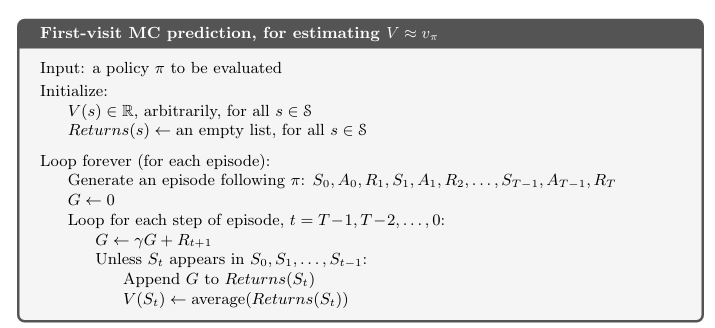

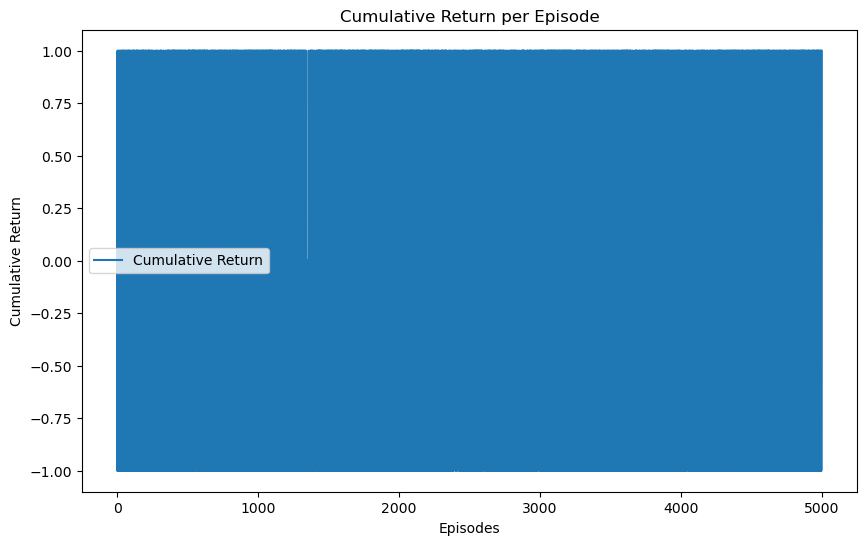

In [20]:

class MonteCarloAgent:
    def __init__(self, env, discount_factor=1.0, epsilon=0.5, min_epsilon=0.1):
        self.env = env
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon

        # Initialize Q-value table for state-action pairs using zeros 
        self.q_value_table = defaultdict(lambda: np.zeros(self.env.action_space.n))
        
        # store returns for each state-action pair
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(int)
        
        # Store cumulative rewards over time
        self.cumulative_returns = []


    # epsilon greedy action to follow s&b
    def get_epsilon_greedy_action(self, state):

        if random.uniform(0, 1) > self.epsilon:

            return np.argmax(self.q_value_table[state]) 
        
        # random action
        else:
            return self.env.action_space.sample() 


    # generate episode
    def generate_episode(self):

        episode = []

        # reset environment return first observation (s0) e info
        state, _ = self.env.reset()  
        
        while True:
            # perform e greedy action given initial state s0
            action = self.get_epsilon_greedy_action(state)
            # go to s1 e reward r and check if episode ended ( player stay or bust)
            next_state, reward, done, _, _ = self.env.step(action)
            # add to generated episodes
            episode.append((state, action, reward))


            if done:
                break
            state = next_state
        
        return episode



    # learn from generated episode means compute average return for each state we econounter and this will approximate its V(S)
    def learn(self, episode):

        # Initialize return
        visited_state_actions = set()
        G = 0  
        
        # Process episode in reverse to calculate returns
        for state, action, reward in reversed(episode):

            # Mc G = Rt+1+ gamma * G
            G = reward + self.discount_factor * G
            state_action_pair = (state, action)
            
            # First-visit MC update -> we have to write down visited s-a pairs
            if state_action_pair not in visited_state_actions:
                visited_state_actions.add(state_action_pair)
                
                # Incremental update of Q-values -> increase return and compute average returns
                self.returns_sum[state_action_pair] += G
                self.returns_count[state_action_pair] += 1
                self.q_value_table[state][action] = self.returns_sum[state_action_pair] / self.returns_count[state_action_pair]


    def train(self, num_episodes, plot=False, plot_frequency=50):
        for episode in range(1, num_episodes + 1):
            # Epsilon decay
            self.epsilon = max(self.min_epsilon, self.epsilon * 0.99)
            
            # Generate an episode
            episode_data = self.generate_episode()
            
            # Learn from the episode
            self.learn(episode_data)
            
            # Store cumulative rewards of episode x[2] is the reward of episode 
            self.cumulative_returns.append(sum([x[2] for x in episode_data]))
            
            # Plot results at specified intervals
            self.update_plot(episode, plot, plot_frequency)


    def update_plot(self, episode, plot, plot_frequency=50):
        

        if plot and episode % plot_frequency == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(self.cumulative_returns, label='Cumulative Return')
            plt.xlabel('Episodes')
            plt.ylabel('Cumulative Return')
            plt.title('Cumulative Return per Episode')
            plt.legend()
            plt.show()
            plt.close()

# 5000 episodes otherwise too much time 
training_episodes = 5000

# Initialize Blackjack environment
env = gym.make('Blackjack-v1', natural=False, sab=False)
env_mc = gym.wrappers.RecordEpisodeStatistics(env, deque_size= training_episodes)

# Initialize Monte Carlo Agent
mc_agent = MonteCarloAgent(env)

# Train the agent for a specified number of episodes

mc_agent.train(training_episodes, plot=True)

# Plot the cumulative returns to see performance over time
mc_agent.update_plot(training_episodes, plot=True)


In [21]:

wins = 0 
loss= 0 

# take returns and lenght of the environment 
env_returns_list =  mc_agent.cumulative_returns

# if return positive the episode was a win, if negative  loss
for reward in env_returns_list:
    if reward > 0:
        wins += 1
    elif reward < 0:
        loss += 1
# percentage of win, lossa and average length of the game
winsoveround = wins / training_episodes
lossoveround = loss / training_episodes


perf = ["Monte Carlo", winsoveround, lossoveround, "NA"]

perf


['Monte Carlo', 0.394, 0.539, 'NA']

In [27]:
df_final = df4.copy()
df_final.loc[len(df)] = perf
df_final

,Model Name,Winning Percentage,Loss Percentage,AVG Episode Length
0,Random Model,0.28036,0.67579,1.37603
1,Q learning,0.38618,0.53903,1.4552
2,SARSA1,0.26265,0.69293,1.5209
3,SARSA2,0.25806,0.69798,1.52019
4,Monte Carlo,0.39400,0.53900,NA


MonteCarlo performs better than the other models, even Q-learning.    
Our main interpretation is that Blackjack even though it may theoretically benefit from an off-policy approach retains one key characteristic: episodes tend to be short.    
   
Even if we used an On-policy MC  the model performs better probably because it can update values at the end of the episode and not just after a step.   
This ensure a more robust and precise update rather than the TD approach that updates at every step.   



## **Conclusions**  

Although we have reasoned that an off-policy model can theoretically perform better in the game of Blackjack we can see how the Monte Carlo performed the best.

However it is important to note that the Monte Carlo model we have constructed has two major pro and con:
- **The pro** is that it can improve a lot since it uses only 5000 episodes instead of 100 000
- **The con** is that it is very slow and 5000 episodes take 2.30 minutes

So in conclusion Q-learning (TD) performs well and fast but Monte Carlo seems to be able to perform better with more computing capacity or time and it would be worth comparing the various models as MC exploring start or off policy MC .